<a href="https://colab.research.google.com/github/Kunind27/Graph-Similarity-Computation/blob/main/NN2Graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes = True)
%matplotlib inline

In [2]:
import torch
import networkx as nx

!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install torch-geometric
import torch_geometric

Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
     |████████████████████████████████| 8.0 MB 4.3 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
     |████████████████████████████████| 2.9 MB 4.1 MB/s 
     |████████████████████████████████| 308 kB 4.0 MB/s 
     |████████████████████████████████| 376 kB 29.0 MB/s 
     |████████████████████████████████| 45 kB 3.2 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.0-py3-none-any.whl size=513273 sha256=a98d50dc10a95e73dee113f7788bc6267063568aa2a4aa675767e2b1796efe81
  Stored in directory: /root/.cache/pip/wheels/b5/22/3f/10c97635d8d73e012582116b4e449d47fc64b7246cc71085fc
Successfully built torch-geometric


In [3]:
from torch import nn

# Neural Network Specifications : 
class neural_network(torch.nn.Module):
    def __init__(self, input_dim = 784, hidden_layer_dim = 25, output_dim = 10):
        super(neural_network, self).__init__()
        self.nn_model = nn.Sequential(nn.Linear(input_dim, hidden_layer_dim),
                                      nn.ReLU(),
                                      nn.Linear(hidden_layer_dim, output_dim),
                                      nn.Softmax())
    def forward(self, input):
        return self.nn_model(input)

In [4]:
model = neural_network(input_dim = 2, hidden_layer_dim = 3, output_dim = 1)
print(model)

neural_network(
  (nn_model): Sequential(
    (0): Linear(in_features=2, out_features=3, bias=True)
    (1): ReLU()
    (2): Linear(in_features=3, out_features=1, bias=True)
    (3): Softmax(dim=None)
  )
)


In [5]:
model.parameters

<bound method Module.parameters of neural_network(
  (nn_model): Sequential(
    (0): Linear(in_features=2, out_features=3, bias=True)
    (1): ReLU()
    (2): Linear(in_features=3, out_features=1, bias=True)
    (3): Softmax(dim=None)
  )
)>

In [6]:
model.state_dict()

OrderedDict([('nn_model.0.weight', tensor([[-0.3129, -0.4216],
                      [-0.1164,  0.3219],
                      [-0.3994, -0.6330]])),
             ('nn_model.0.bias', tensor([ 0.1072,  0.3362, -0.6118])),
             ('nn_model.2.weight', tensor([[-0.5090, -0.3304,  0.2319]])),
             ('nn_model.2.bias', tensor([0.3704]))])

In [7]:
for obj in model.children():
    print(obj)

Sequential(
  (0): Linear(in_features=2, out_features=3, bias=True)
  (1): ReLU()
  (2): Linear(in_features=3, out_features=1, bias=True)
  (3): Softmax(dim=None)
)


In [8]:
for i in model.state_dict().keys():
    print(i)
    print(model.state_dict()[i])

nn_model.0.weight
tensor([[-0.3129, -0.4216],
        [-0.1164,  0.3219],
        [-0.3994, -0.6330]])
nn_model.0.bias
tensor([ 0.1072,  0.3362, -0.6118])
nn_model.2.weight
tensor([[-0.5090, -0.3304,  0.2319]])
nn_model.2.bias
tensor([0.3704])


In [9]:
for layer_name in model.state_dict().keys():
    print(layer_name)
    print(model.state_dict()[layer_name])
    print(model.state_dict()[layer_name].shape)
    print(model.state_dict()[layer_name].shape[0], end = "")
    if len(model.state_dict()[layer_name].shape) > 1:
        print(" ",model.state_dict()[layer_name].shape[1], end = "")
    print()

nn_model.0.weight
tensor([[-0.3129, -0.4216],
        [-0.1164,  0.3219],
        [-0.3994, -0.6330]])
torch.Size([3, 2])
3  2
nn_model.0.bias
tensor([ 0.1072,  0.3362, -0.6118])
torch.Size([3])
3
nn_model.2.weight
tensor([[-0.5090, -0.3304,  0.2319]])
torch.Size([1, 3])
1  3
nn_model.2.bias
tensor([0.3704])
torch.Size([1])
1


In [10]:
model.state_dict()["nn_model.2.bias"].shape[0]

1

In [11]:
total_neurons = 0

for i, layer in enumerate(model.state_dict().keys()):
    if i%2 == 0:
        total_neurons += model.state_dict()[layer].shape[1] + 1 # No. of Neurons + Bias

# Getting the last bias matrix
last_layer = list(model.state_dict().keys())[-1]
output_neurons = model.state_dict()[last_layer].shape[0]
total_neurons += output_neurons

print(total_neurons)

8


In [12]:
import time
total_neurons = 0

G = nx.MultiGraph()
edge_list = []

tik = time.time()
for layer_num, layer in enumerate(model.state_dict().keys()):
    if layer_num%2 == 0:
        neurons_current_layer = model.state_dict()[layer].shape[1] + 1 # No. of Neurons + Bias
        
        total_neurons += neurons_current_layer # Incrementing the Total by neurons in current layer

        neurons_next_layer = model.state_dict()[layer].shape[0]

        for neuron1 in range(total_neurons - neurons_current_layer, total_neurons):
            G.add_node(neuron1)
            for neuron2 in range(total_neurons, total_neurons + neurons_next_layer):
                G.add_node(neuron2)
                G.add_edge(neuron1, neuron2)
                G.add_edge(neuron2, neuron1)
                edge_list.append([neuron1, neuron2])
                edge_list.append([neuron2, neuron1])

tok = time.time()
print(tok-tik)

0.00042939186096191406


In [13]:
total_neurons

7

In [14]:
print(G.nodes())
print(G.edges())
print(edge_list)

[0, 3, 4, 5, 1, 2, 7, 6]
[(0, 3), (0, 3), (0, 4), (0, 4), (0, 5), (0, 5), (3, 1), (3, 1), (3, 2), (3, 2), (3, 7), (3, 7), (4, 1), (4, 1), (4, 2), (4, 2), (4, 7), (4, 7), (5, 1), (5, 1), (5, 2), (5, 2), (5, 7), (5, 7), (7, 6), (7, 6)]
[[0, 3], [3, 0], [0, 4], [4, 0], [0, 5], [5, 0], [1, 3], [3, 1], [1, 4], [4, 1], [1, 5], [5, 1], [2, 3], [3, 2], [2, 4], [4, 2], [2, 5], [5, 2], [3, 7], [7, 3], [4, 7], [7, 4], [5, 7], [7, 5], [6, 7], [7, 6]]


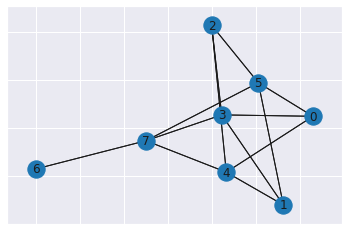

In [15]:
nx.draw_networkx(G)

In [16]:
for layer in model.parameters():
    print(layer)

Parameter containing:
tensor([[-0.3129, -0.4216],
        [-0.1164,  0.3219],
        [-0.3994, -0.6330]], requires_grad=True)
Parameter containing:
tensor([ 0.1072,  0.3362, -0.6118], requires_grad=True)
Parameter containing:
tensor([[-0.5090, -0.3304,  0.2319]], requires_grad=True)
Parameter containing:
tensor([0.3704], requires_grad=True)
